In [3]:
import sys
sys.path.extend(['./yolov5', './yolov5/utils'])
from yolov5.utils.metrics import box_iou, compute_ap

from yolov5_predictor import Yolov5_Predictor
from unet_predictor import UNet_Predictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

from constants import CLS_NAMES
from predictor_utils import load_json_label, load_img
import time


def compute_metric(pred: np.ndarray , gt: np.ndarray, ap_threshold = 0.5) -> dict:
    """
    Args:
        pred: a shape of (N, 6) ndarray, [x1, y1, x2, y2, conf, cls_idx]
        gt: a shape of (N, 5) ndarray, [x1, y1, x2, y2, cls_idx]
        ap_threshold: the thrshold for AP. Default is 0.5, which mean AP50.
    Return:
        a dict of (cls_idx, (AP, mean_iou))
    """
    # sort by conf
    conf_rank = np.argsort(pred[:, 4])[::-1]
    pred = pred[conf_rank]
    unique_cls = np.unique(pred[:,5])

    cls_result = dict()
    for cls_idx in unique_cls:
        cls_gt =  gt[gt[:,4] == cls_idx]
        cls_pred = pred[pred[:,5] == cls_idx]
        n_pred = len(cls_pred)
        n_gt = len(cls_gt)
        if len(cls_gt) == 0:
            cls_result[int(cls_idx)] = (np.zeros(n_pred), np.zeros(n_pred), 0.0)
            continue

        gt_box = cls_gt[:, :4]
        pred_box = cls_pred[:, :4]
        pred_conf = cls_pred[:, 4]
        ious = box_iou(torch.from_numpy(gt_box), torch.from_numpy(pred_box)).numpy()

        ious = ious.max(axis=0)
        mean_iou = np.mean(ious)
        true_target = ious > 0.5 # AP50

        TP = np.array([np.count_nonzero(true_target[:i+1]) for i in range(n_pred)])
        FP = (np.arange(n_pred) + 1) - TP

        recall = TP / n_gt 
        precision = TP / (np.arange(n_pred) + 1)
        cls_name = CLS_NAMES[int(cls_idx)]
        cls_result[cls_name] = (recall, precision, mean_iou)


    for cls_name, (recall, precision, mean_iou) in cls_result.items():
        ap, _, _ = compute_ap(recall, precision)
        cls_result[cls_name] = (ap, mean_iou)
    return cls_result

def dice_coeff(input: np.ndarray, target: np.ndarray, epsilon: float = 1e-6) -> float:
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.shape == target.shape
    assert len(input.shape) == 2

    _, input = cv2.threshold(input, 0, 1, cv2.THRESH_BINARY)
    input = input.astype(np.int32)
    _, target = cv2.threshold(target, 0, 1, cv2.THRESH_BINARY)
    target = target.astype(np.int32)

    inter = 2 * (input * target).sum()
    sets_sum = input.sum() + target.sum()
    sets_sum = np.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return np.mean(dice)

def draw_bbox(im, bboxes: np.ndarray) -> np.ndarray:
    if isinstance(im, str):
        im = load_img(im)
    lw = int(max(round(sum(im.shape) / 2 * 0.003), 2) * 1.5)
    txt_color = (220, 220, 220)
    box_color = (255, 0, 0)
    for box in bboxes:
        cls_idx = int(box[5])
        color = (255, 0, 0)
        # cv2.rectangle(im , (x1, y1), (x2, y2), bbox_color, 6, cv2.LINE_AA)
        
        p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
        cv2.rectangle(im, p1, p2, box_color, thickness=lw, lineType=cv2.LINE_AA)

        tf = max(lw - 1, 1)  # font thickness
        label = CLS_NAMES[cls_idx]
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(im, p1, p2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(im,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv2.LINE_AA)
    return im

class Powder_Spreading_Predictor(object):
    def __init__(self, yolo_weight_path:str, 
                        unet_weight_path:str,
                        bilinear=True,
                        crop_size=(320,320),
                        device:str = 'cpu'):
        self.yolov5_predictor = Yolov5_Predictor(yolo_weight_path, device=device)
        self.unet_predictor = UNet_Predictor(unet_weight_path, bilinear=bilinear, device=device)
        self.crop_size = crop_size

    def predict(self, img_path: str, mask_path:str, label_path: str):
        # Start to compute spending time
        start = time.time()
        metrics = dict()
        
        # Load image
        im = load_img(img_path)
        im_h, im_w , c = im.shape
        
        # Predict by yolov5
        pred_bboxes, crop_imgs, crop_box_infos = self.yolov5_predictor.predict_crop(img_path)

        # Not found any target in image
        if not isinstance(pred_bboxes, np.ndarray):
            metrics['detect'] = dict()
            metrics['pred_cls_name'] = 'None'
            metrics['dice'] = 0.0
            pred_mask = np.zeros((im_h, im_w))
            return im, pred_mask, metrics
        

        # Predict by UNet based on the result of yolov5
        pred_mask = np.zeros((im_h, im_w))
        for crop_img, box_info in zip(crop_imgs, crop_box_infos):
            box_w, box_h, x1, y1, x2, y2 = box_info
            origin_size = (box_w, box_h)
            # Resize the crop image into the input size of UNet
            resized_crop_img = cv2.resize(crop_img, self.crop_size) 
            unet_pred = self.unet_predictor.predict(cv2.cvtColor(resized_crop_img, cv2.COLOR_BGR2RGB), to_img=True) # Unet use Pillow, so we need to convert from BGR to RGB

            # Resize the result of predict img from UNet to origin size
            pred_mask[y1:y2, x1:x2] = cv2.resize(unet_pred, origin_size, interpolation=cv2.INTER_NEAREST)

        end = time.time()
        spending_time = end - start


        # Compute metrics
        gt_bboxes = load_json_label(label_path)
        metrics['detect'] = compute_metric(pred_bboxes, gt_bboxes)

        pred_cls_idx = int(np.argmax(np.bincount(np.array(pred_bboxes[:, 5].astype(np.int64)), minlength = 3)))
        metrics['pred_cls_name'] = CLS_NAMES[pred_cls_idx]
        # Calculate dice coefficient
        gt_mask = load_img(mask_path, binary=True)
        metrics['dice'] = dice_coeff(pred_mask, gt_mask)
        metrics['fps'] = spending_time

        pred_img = draw_bbox(im, pred_bboxes)
        return pred_img, pred_mask, metrics
    

In [4]:
import cv2
import numpy as np

yolo_weight = './yolov5/runs/train/[2023-01-07-0005]960_bs16_med_E300_fold1/weights/best.pt'
unet_weight = './UNet/ckp_fold1/checkpoint_epoch40.pth'
device = 'cuda'
predictor = Powder_Spreading_Predictor(yolo_weight, unet_weight, device=device)

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs


In [75]:
from os.path import join
raw_name = 'converted_ 0005'
data_root = './data/raw/Train/powder_uneven/'
img_name = raw_name + '.png'
label_name = raw_name + '.json'

img_path = join(data_root, 'image', img_name)
label_path = join(data_root, 'label', label_name)
mask_path = join(data_root, 'mask', img_name)

pred_img, pred_mask, metrics = predictor.predict(img_path, mask_path, label_path)




In [1]:
label_path = 'D:/研究所課程/孫永年影像處理/homework/ncku_image_processing/final_hw/data/raw/Train/scratch/label/Converted_ 0008.json'
from predictor_utils import load_json_label
import json

with open(label_path, 'r') as f:
    data = json.load(f)

In [4]:
import os
from os.path import join
raw_name = 'converted_ 0005'
data_root = os.path.abspath('./data/raw/Train/powder_uneven/')
img_name = raw_name + '.png'
label_name = raw_name + '.json'

img_path = join(data_root, 'image', img_name)
label_path = join(data_root, 'label', label_name)
mask_path = join(data_root, 'mask', img_name)

load_json_label(label_path)

array([[9.85714286e+00, 2.15800000e+03, 3.37592857e+03, 2.33657143e+03,
        1.00000000e+00],
       [1.70000000e+01, 2.55264286e+03, 3.37950000e+03, 2.73121429e+03,
        1.00000000e+00]])

In [8]:
import numpy as np
def cv_imread(path):
    im = cv2.imdecode(np.fromfile(path, dtype=np.uint8), -1)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    return im
im = cv_imread(img_path)
im.shape

(3330, 3384, 3)

In [12]:
import cv2
from predictor_utils import cv_imread, load_img
path = './predict_result\\seg\\0.png'
im = load_img(path)
im.shape

(3330, 3384, 3)

In [5]:
import cv2
cv2.imread(img_path)

In [92]:
import os
from os.path import join
raw_name = 'converted_ 0005'

data_root = './data/raw/Train/scratch/'
img_name = raw_name + '.png'
label_name = raw_name + '.json'

seg_ratio = []
for img_name in os.listdir(join(data_root, 'image')):
    img_path = join(data_root, 'image', img_name)

    im = load_img(img_path)
    im_h, im_w , c = im.shape

    # Predict by yolov5
    pred_bboxes, crop_imgs, crop_box_infos = predictor.yolov5_predictor.predict_crop(img_path)


    # Predict by UNet based on the result of yolov5
    pred_mask = np.zeros((im_h, im_w))
    for crop_img, box_info in zip(crop_imgs, crop_box_infos):
        box_w, box_h, x1, y1, x2, y2 = box_info
        origin_size = (box_w, box_h)
        # Resize the crop image into the input size of UNet
        resized_crop_img = cv2.resize(crop_img, predictor.crop_size) 
        unet_pred = predictor.unet_predictor.predict(cv2.cvtColor(resized_crop_img, cv2.COLOR_BGR2RGB), to_img=True) # Unet use Pillow, so we need to convert from BGR to RGB

        resize_unet_pred = cv2.resize(unet_pred, origin_size, interpolation=cv2.INTER_NEAREST)
        area = box_w * box_h
        seg_area = np.count_nonzero(resize_unet_pred)
        seg_ratio.append(seg_area / area)
        # Resize the result of predict img from UNet to origin size
        pred_mask[y1:y2, x1:x2] = resize_unet_pred

In [93]:
np.mean(seg_ratio)


0.4621220625491626

In [94]:
np.sort(seg_ratio)

array([     0.3267,     0.32808,     0.32876,     0.32931,     0.33042,     0.33114,     0.33141,     0.33146,     0.33224,     0.33305,     0.33481,     0.33521,     0.33534,     0.33629,     0.33637,      0.3368,     0.33707,     0.33746,     0.33758,     0.33763,     0.33771,     0.33781,     0.33804,     0.33822,
           0.33839,     0.33846,     0.33855,     0.33871,     0.33873,     0.33877,     0.33881,     0.33926,     0.33955,     0.33975,     0.33982,     0.33997,     0.34013,     0.34043,     0.34057,     0.34096,     0.34102,     0.34121,     0.34128,     0.34203,     0.34274,     0.34293,       0.343,      0.3435,
           0.34388,     0.34395,     0.34408,      0.3441,     0.34437,     0.34468,     0.34498,     0.34513,     0.34521,     0.34577,     0.34664,     0.34823,      0.3497,      0.3499,     0.35427,     0.35563,     0.35652,     0.35784,     0.35847,      0.3634,     0.36392,     0.36469,     0.36559,     0.36781,
            0.3689,     0.37414,     0.3769

In [90]:
np.sort(seg_ratio)

array([  0.0030911,   0.0066141,     0.20047,     0.22273,     0.23792,     0.24462,     0.26431,     0.27026,     0.27908,     0.42281,     0.42362,     0.42687,     0.42738,     0.42857,     0.42862,     0.42917,     0.42972,     0.43048,     0.43065,     0.43086,     0.43105,     0.43189,     0.43257,     0.43484,
           0.43497,     0.43725,     0.43901,     0.43936,      0.4403,     0.44121,     0.44715,     0.45057,     0.45247,     0.45736,     0.45744,     0.46222,     0.46574,     0.47104,     0.47458,     0.47971,     0.51122,     0.51481,     0.52591,     0.53429,      0.5503,      0.5549,     0.55654,     0.56202,
           0.58203,     0.58702,     0.68063,       0.685,     0.68596,     0.68738,     0.69009,     0.69014,     0.69323,     0.69338,      0.6938,     0.69641,     0.69842,     0.70009,     0.70114,     0.70201,     0.70625,     0.70701,     0.71598,     0.71784,     0.72192,     0.72456,     0.72582,     0.72766,
           0.72824,     0.72991,     0.7347

In [86]:
sseg_ratio

[0.4710445735210556,
 0.4402968371871809,
 0.0030911470661951043,
 0.46222358045901063,
 0.4393598552009456,
 0.4657420825739777,
 0.439014712223263,
 0.006614121263762885,
 0.47971203160465903,
 0.42971595265478246,
 0.47457840819542946,
 0.4291654605104453,
 0.22272684016508396,
 0.4306506849315068,
 0.20047156421244347,
 0.4308581479322517,
 0.23792082274560372,
 0.4304804091215585,
 0.24462181574080707,
 0.4228079216667894,
 0.2702592029719689,
 0.4310521313153469,
 0.2643075546847307,
 0.42856869104962925,
 0.27907801418439715,
 0.4268745726970948,
 0.4573589546993802,
 0.42361722507540556,
 0.45744285522268874,
 0.42737527512839324,
 0.5565436327573209,
 0.4348428799195746,
 0.5620201508499381,
 0.43725473808216125,
 0.5342866855173906,
 0.42862408910336086,
 0.5549043756458714,
 0.4412092545105921,
 0.5870249945633492,
 0.44714962790662316,
 0.5820268311352259,
 0.4524724192277384,
 0.5112182328605201,
 0.43497165453527437,
 0.5148103959994992,
 0.43189374352649096,
 0.525909039

In [87]:
np.mean(seg_ratio)

0.6099640177805697

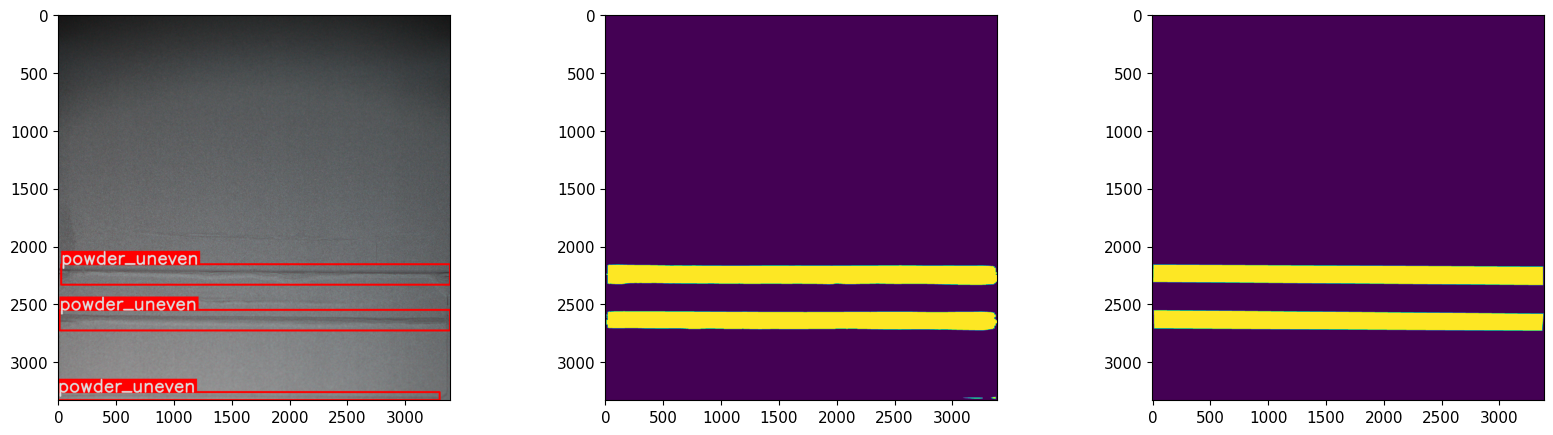

In [76]:
%matplotlib inline

plt.figure(figsize=(20,5 ))

ax = plt.subplot(1,3,1)
ax.imshow(pred_img)

ax = plt.subplot(1,3,2)
ax.imshow(pred_mask)

ax = plt.subplot(1,3,3)
ax.imshow(load_img(mask_path, binary=True))

In [83]:
im = load_img(img_path)
im_h, im_w , c = im.shape

# Predict by yolov5
pred_bboxes, crop_imgs, crop_box_infos = predictor.yolov5_predictor.predict_crop(img_path)


# Predict by UNet based on the result of yolov5
pred_mask = np.zeros((im_h, im_w))
for crop_img, box_info in zip(crop_imgs, crop_box_infos):
    box_w, box_h, x1, y1, x2, y2 = box_info
    origin_size = (box_w, box_h)
    # Resize the crop image into the input size of UNet
    resized_crop_img = cv2.resize(crop_img, predictor.crop_size) 
    unet_pred = predictor.unet_predictor.predict(cv2.cvtColor(resized_crop_img, cv2.COLOR_BGR2RGB), to_img=True) # Unet use Pillow, so we need to convert from BGR to RGB

    resize_unet_pred = cv2.resize(unet_pred, origin_size, interpolation=cv2.INTER_NEAREST)
    area = box_w * box_h
    seg_area = np.count_nonzero(resize_unet_pred)
    print(seg_area / area)
    # Resize the result of predict img from UNet to origin size
    pred_mask[y1:y2, x1:x2] = resize_unet_pred

    area = box_w * box_h
seg_area = np.count_nonzero(resize_unet_pred)
seg_area = area

0.4710445735210556
0.4402968371871809
0.0030911470661951043


0.0030911470661951043

In [ ]:
%matplotlib inline

ax = plt.subplot(1,2,1)
ax.imshow(pred_img)

ax = plt.subplot(1,2,2)
ax.imshow(pred_mask)


In [14]:
im.shape

(3330, 3384, 3)

In [15]:
(empty_mask != 0).shape

(3330, 3384)

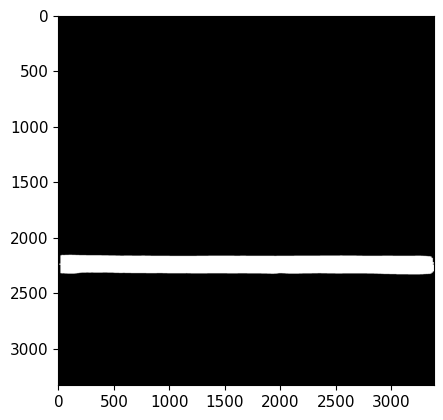

In [56]:
im = load_img(img_path)
im_h, im_w , c = im.shape
marker = np.zeros((im_h, im_w), dtype=np.int32)

gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
marker[y1:y2, x1:x2] = cv2.resize(unet_pred, origin_size, interpolation=cv2.INTER_NEAREST)
# _ , gray_im = cv2.threshold(gray_im, 0, , cv2.THRESH_BINARY)
result = cv2.watershed(im, marker)

In [57]:
im[result != -1] = (0, 0, 0)

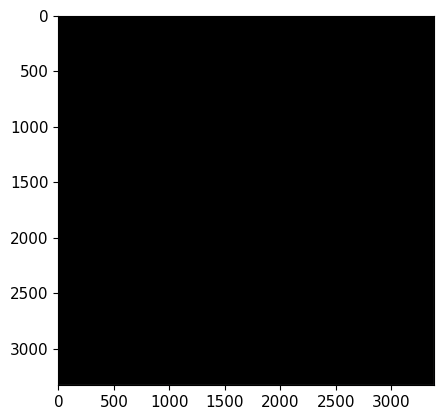

In [58]:
plt.imshow(im)

In [ ]:
# 1.图像二值化
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

kernel = np.ones((3, 3), dtype=np.uint8)
# 2.噪声去除
open = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
# 3.确定背景区域
sure_bg = cv2.dilate(open, kernel, iterations=3)
# 4.寻找前景区域
dist_transform = cv2.distanceTransform(open, 1, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, cv2.THRESH_BINARY)
# 5.找到未知区域
sure_fg = np.uint8(sure_fg)
unknow = cv2.subtract(sure_bg, sure_fg)

# 6.类别标记
ret, markers = cv2.connectedComponents(sure_fg)
# 为所有的标记加1，保证背景是0而不是1
markers = markers + 1
# 现在让所有的未知区域为0
markers[unknow == 255] = 0

# 7.分水岭算法
markers = cv2.watershed(img, markers)
img[markers == -1] = (0, 0, 255)

array([          0,         255])

In [ ]:
cv2.watershed()

In [25]:
im[target_mask == 0].shape

(32194611,)

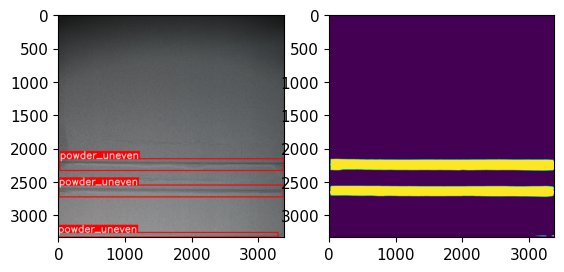

In [7]:
%matplotlib inline

ax = plt.subplot(1,2,1)
ax.imshow(pred_img)

ax = plt.subplot(1,2,2)
ax.imshow(pred_mask)


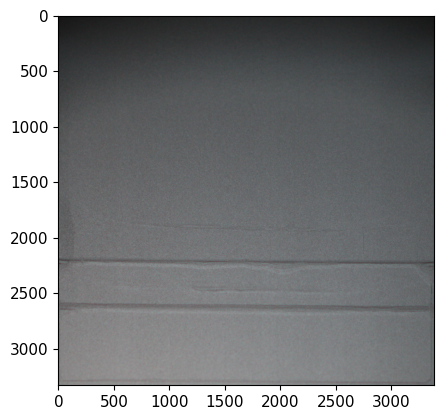

In [9]:
%matplotlib inline
plt.imshow(im)

In [3]:
import os
from os.path import join
from tqdm import tqdm
from collections import defaultdict

split = 'Val'
data_root = './data/yolov5/{}'.format(split)

dice_scores = []
cls_dice_scores = defaultdict(list)
for img_name in tqdm(os.listdir(join(data_root, 'images'))):
    img_path = join(data_root, 'images', img_name)
    mask_path = join(data_root, 'masks', img_name)
    
    predicted_mask, cls_name = predictor.predict(img_path)
    gt_mask = load_img(mask_path ,binary=True)
    dice = dice_coeff(predicted_mask, gt_mask)
    cls_dice_scores[cls_name].append(dice)
    dice_scores.append(dice)
print(np.mean(dice_scores))
for cls_name, scores in cls_dice_scores.items():
    print(cls_name, np.mean(scores))

100%|██████████| 150/150 [01:03<00:00,  2.35it/s]

0.867521616074514
powder_uncover 0.7949520904089215
powder_uneven 0.9340854960740012
scratch 0.8735272617406187


In [3]:
import os
from os.path import join
from tqdm import tqdm
from collections import defaultdict

split = 'Val'
data_root = './data/yolov5/{}'.format(split)

dice_scores = []
cls_dice_scores = defaultdict(list)
for img_name in tqdm(os.listdir(join(data_root, 'images'))):
    img_path = join(data_root, 'images', img_name)
    mask_path = join(data_root, 'masks', img_name)
    
    predicted_mask, cls_name = predictor.predict(img_path)
    gt_mask = load_img(mask_path ,binary=True)
    dice = dice_coeff(predicted_mask, gt_mask)
    cls_dice_scores[cls_name].append(dice)
    dice_scores.append(dice)
print(np.mean(dice_scores))
for cls_name, scores in cls_dice_scores.items():
    print(cls_name, np.mean(scores))

100%|██████████| 150/150 [01:03<00:00,  2.36it/s]

0.9003009147148221
powder_uncover 0.7949520904089215
powder_uneven 0.9340854960740012
scratch 0.9718651576615441


In [6]:
import os
from os.path import join
from tqdm import tqdm
from collections import defaultdict

split = 'Val'
data_root = './data/yolov5/{}'.format(split)

dice_scores = []
cls_dice_scores = defaultdict(list)
for img_name in tqdm(os.listdir(join(data_root, 'images'))):
    img_path = join(data_root, 'images', img_name)
    mask_path = join(data_root, 'masks', img_name)
    
    predicted_mask, cls_name = predictor.predict(img_path)
    gt_mask = load_img(mask_path ,binary=True)
    dice = dice_coeff(predicted_mask, gt_mask)
    cls_dice_scores[cls_name].append(dice)
    dice_scores.append(dice)
print(np.mean(dice_scores))
for cls_name, scores in cls_dice_scores.items():
    print(cls_name, np.mean(scores))

100%|██████████| 150/150 [01:04<00:00,  2.34it/s]

0.9015540226364815
powder_uncover 0.7982109480866161
powder_uneven 0.9362508999937795
scratch 0.9702002198290482


In [ ]:
import matplotlib.pyplot as plt
import os
from os.path import join
%matplotlib inline



predictor.unet_predictor.threshold = 0.5
split = 'Val'


for i in range(10, 20):
    img_name = '/scratch_{}.png'.format(i)

    mask_path = './data/yolov5/{}/masks/{}'.format(split, img_name)
    img_path = './data/yolov5/{}/images/{}'.format(split, img_name)

    label_txt = './data/unet/{}/labels/{}.txt'.format(split, img_name.split('.')[0])
    with open(label_txt, 'r') as f:
        lines = f.readlines()
    
    predicted_mask = predictor.predict(img_path)
    gt_mask = load_img(mask_path, binary=True)


    print(dice_coeff(predicted_mask, gt_mask))
    #   
    # im_h, im_w = result.shape
    # gt_unet_mask = np.zeros((im_h, im_w))
    # for line in lines:
    #     mask_name = line.split(',')[0]
    #     box_w, box_h, x1, y1, x2, y2 = [int(c) for c in line.split(',')[1:]]
    #     mask = load_img('./data/unet/{}/masks/{}'.format(split, mask_name), True)
    #     mask = cv2.resize(mask, (box_w, box_h), interpolation=cv2.INTER_NEAREST)
    #     gt_unet_mask[y1:y2, x1:x2] = mask
    

    # gt_mask = load_img(mask_path, binary=True)

    # ax = plt.subplot(1,3,1)
    # ax.imshow(result)

    # ax = plt.subplot(1,3,2)
    # ax.imshow(gt_unet_mask)


    # ax = plt.subplot(1,3,3)
    # ax.imshow(gt_mask)

    # plt.show()

In [ ]:
yolov5_predictor = Yolov5_Predictor(yolo_weight, device=device)
unet_predictor = UNet_Predictor(unet_weight, device=device)

In [ ]:
im = cv2.imread(img_path)
im_h, im_w , c = im.shape
crop_imgs, box_infos = yolov5_predictor.predict_crop(img_path)
predicted_mask = np.zeros((im_h, im_w))

In [ ]:
resized_size = (320, 320)
for crop_img, box_info in zip(crop_imgs, box_infos):
    box_w, box_h, x1, y1, x2, y2 = box_info
    origin_size = (box_w, box_h)
    predict_mask = unet_predictor.predict(cv2.cvtColor(cv2.resize(crop_img, resized_size), cv2.COLOR_BGR2RGB), to_img=True)

    plt.imshow(predict_mask)
    plt.show()

In [3]:
%cd UNet

d:\研究所課程\孫永年影像處理\homework\ncku_image_processing\final_hw\UNet\UNet


In [6]:
!python my_train_k_fold.py --k-fold 11 --epoch 60 --bilinear

python: can't open file 'my_train_k_fold.py': [Errno 2] No such file or directory


In [ ]:
! python my_train.py --k-fold 4 --epoch 60 --bilinear